# Chapter 17: E-Value : Evidence for Causation in Observational Studies with Unmeasured Confounding

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

numpy            : 1.24.3
pandas           : 2.0.3
matplotlib       : 3.7.2
seaborn          : 0.13.0
scipy            : 1.11.1
statsmodels      : 0.14.0
graphviz         : 0.20.1
matplotlib_inline: 0.1.6



With observed conditional risk ration $\text{RR}^{\text{obs}}_{ZY \mid X}$, we can calculate the E-value as follows:

In [2]:
def evalue(rr):
    return rr + np.sqrt(rr * (rr - 1))

In [5]:
## Analysis
p1 = 397 / (397 + 78557)
p0 = 51 / (51 + 108778)

## Relative Risk
(rr := p1 / p0)

10.7297803585806

In [ ]:
## Asymptotic Variance of Log of RR
logrr = np.log(p1 / p0)
se = np.sqrt(1 / 397 + 1 / 51 - 1 / (397 + 78557) - 1 / (51 + 108778))
upper = np.exp(logrr + 1.96 * se)
lower = np.exp(logrr - 1.96 * se)

In [14]:
## point estimate
print(rr)
## e-value based on rr
print(evalue(rr))

10.7297803585806
20.94733418446287


In [15]:
## lower CI
print(lower)
## e-value based on lower CI
print(evalue(lower))

8.017414334809697
15.518182180917343


/tmp/ipykernel_30947/463092966.py:13: RuntimeWarning: divide by zero encountered in divide
  y = RR * (RR - 1) / (x - RR) + RR
/tmp/ipykernel_30947/463092966.py:14: RuntimeWarning: divide by zero encountered in divide
  y_L = RR_L * (RR_L - 1) / (x_L - RR_L) + RR_L


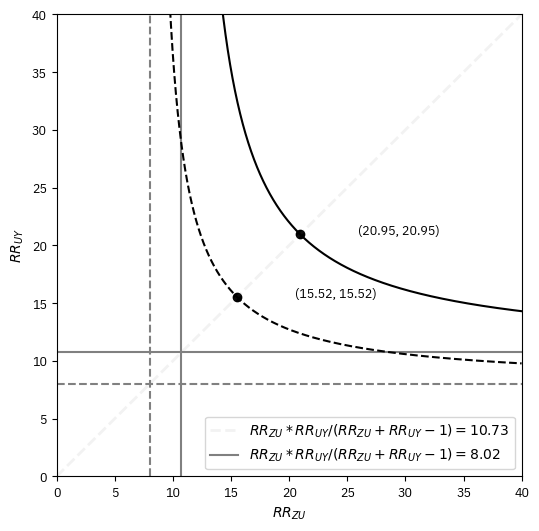

In [34]:
# Figure 17.1
# bias factor and hyperbola
RR = rr
RR_L = lower
xmax = 40
x = np.arange(0, xmax, 0.01)
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x, x, linestyle="--", color="grey", alpha=0.1, linewidth=2)
ax.set_xlabel(r"$RR_{ZU}$")
ax.set_ylabel(r"$RR_{UY}$")
x = np.arange(RR, xmax, 0.01)
x_L = np.arange(RR_L, xmax, 0.01)
y = RR * (RR - 1) / (x - RR) + RR
y_L = RR_L * (RR_L - 1) / (x_L - RR_L) + RR_L
ax.axhline(y=RR, linestyle="-", color="grey")
ax.axhline(y=RR_L, linestyle="--", color="grey")
ax.axvline(x=RR, linestyle="-", color="grey")
ax.axvline(x=RR_L, linestyle="--", color="grey")
ax.plot(x, y, linestyle="-", color="black")
ax.plot(x_L, y_L, linestyle="--", color="black")
high = RR + np.sqrt(RR * (RR - 1))
high_L = RR_L + np.sqrt(RR_L * (RR_L - 1))
ax.scatter(high, high, marker="o", color="black")
ax.scatter(high_L, high_L, marker="o", color="black")
ax.text(high_L + 5, high_L, "(15.52, 15.52)")
ax.text(high + 5, high, "(20.95, 20.95)")
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.legend(
    [
        r"$RR_{ZU} * RR_{UY} / (RR_{ZU} + RR_{UY} - 1) = 10.73$",
        r"$RR_{ZU} * RR_{UY} / (RR_{ZU} + RR_{UY} - 1) = 8.02$",
    ],
)
plt.show()

## application

In [31]:
NCHS2003 = pd.read_table("NCHS2003.txt", sep="\s+")
NCHS2003.head()

,mar,MINDEXSUM,PTbirth,smoking,drinking,hispanic,black,nativeamerican,asian,agebelow20,ageabove35,somecollege,preeclampsia
0,1,4,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0
1,1,1,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1.0,0.0,0.0,NaN
3,2,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0


In [38]:
y_logit = smf.logit(
    """ PTbirth ~ ageabove35 +
        mar + smoking + drinking + somecollege +
        hispanic + black + nativeamerican + asian
    """,
    data=NCHS2003,
).fit()
est, se = y_logit.params[1], y_logit.bse[1]
est, se

Optimization terminated successfully.
         Current function value: 0.378674
         Iterations 6


(0.2676077954509872, 0.004423678272658207)

In [39]:
est, lower_ci = np.exp(est), np.exp(est - 1.96 * se)
print(est)
print(evalue(est))

1.306834493057289
1.9400658087603366


In [40]:
print(lower_ci)
print(evalue(lower_ci))

1.295552682600102
1.9143451120885522


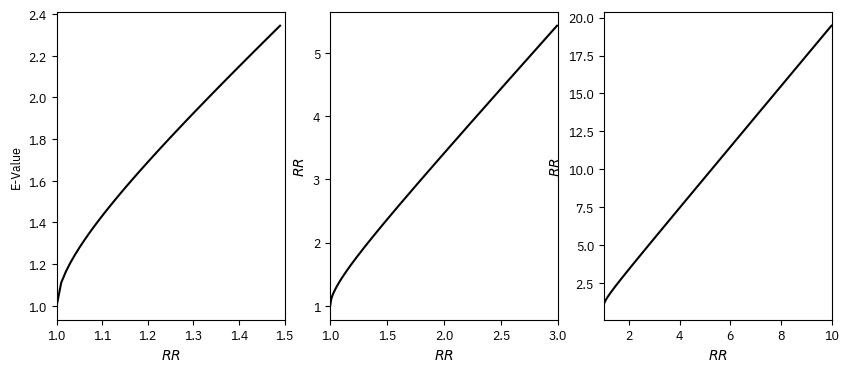

In [43]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
RR1 = np.arange(1, 1.5, 0.01)
ax[0].plot(RR1, evalue(RR1), linestyle="-", color="black")
ax[0].set_xlabel(r"$RR$")
ax[0].set_ylabel(r"E-Value")
ax[0].set_xlim(1, 1.5)

RR2 = np.arange(1, 3, 0.01)
ax[1].plot(RR2, evalue(RR2), linestyle="-", color="black")
ax[1].set_xlabel(r"$RR$")
ax[1].set_ylabel(r"$RR$")
ax[1].set_xlim(1, 3)

RR3 = np.arange(1, 10, 0.01)
ax[2].plot(RR3, evalue(RR3), linestyle="-", color="black")
ax[2].set_xlabel(r"$RR$")
ax[2].set_ylabel(r"$RR$")
ax[2].set_xlim(1, 10)
plt.show()